In [1]:
import os
import meshio
import numpy as np
import pandas as pd
from scipy import ndimage
import netCDF4
from netCDF4 import Dataset
import matplotlib.tri as triangle
import matplotlib.mlab as ml
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cmocean

import datetime as dt

from pylab import *

# display plots in SVG format
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

Read the dataset

In [2]:
outsimple = "378/outputs/out_simple.nc"

fdata = Dataset(outsimple, "r", format="NETCDF4")
ncdata = fdata.variables

In [3]:
# print(fdata.variables)
print(ncdata.keys())
print()
# specific variable
print(ncdata['uav'])

dict_keys(['zc', 'longitude', 'latitude', 'botz', 'time', 'uav', 'vav', 'avg_speed', 'avg_dir', 'u', 'v', 'current_speed', 'current_dir', 'w', 'eta', 'wind_u', 'wind_v', 'wind_mag', 'wind_dir', 'patm', 'dens', 'dens_0', 'Kz', 'Vz', 'bottom_u', 'bottom_v', 'bottom_speed', 'bottom_dir', 'Cd', 'u1mean', 'u2mean', 'wmean', 'u1vmean', 'u2vmean', 'Kzmean', 'tke', 'diss', 'salt', 'temp', 'nhf', 'swr', 'lwr', 'lhf', 'shf', 'alerts_actual', 'alerts_cumulative', 'U1VH0', 'U2VH0', 'vol_cons', 'swr_bot_absorb', 'swr_attenuation', 'swr_transmission'])

<class 'netCDF4._netCDF4.Variable'>
float32 uav(time, j, i)
    coordinates: time latitude longitude
    units: ms-1
    long_name: Eastward depth averaged current
    standard_name: eastward_sea_water_velocity
    vector_name: Depth average currents
    vector_components: uav vav
    valid_range: [-100.  100.]
    missing_value: 1e+35
unlimited dimensions: time
current shape = (4, 30, 50)
filling on, default _FillValue of 9.969209968386869e+36 used


Coordinates

In [4]:
# Get lon,lat coordinates for nodes (depth)
lat = ncdata['latitude'][:].filled(fill_value=0.)
lon = ncdata['longitude'][:].filled(fill_value=0.)

lon.min(),lat.min(),lon.max(),lat.max()

(149.592011749, -19.982301338, 149.650463948, -19.9476798075)

Get variable:

In [5]:
speed = ncdata['avg_speed']
h = ncdata['botz'][:,:].filled(fill_value=0.)
nlay = ncdata['zc'].shape[0]

Get time interval:

In [6]:
start = dt.datetime(1900,3,2,15,0,0)
end = dt.datetime.utcnow()


# Get desired time step  
time_var = ncdata['time']
stime = netCDF4.date2index(start,time_var,select='nearest')
etime = netCDF4.date2index(end,time_var,select='nearest')

dtime = netCDF4.num2date(time_var[stime],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print('RECOM model start time: ',daystr)


dtime = netCDF4.num2date(time_var[etime],time_var.units)
daystr = dtime.strftime('%Y-%b-%d %H:%M')
print('RECOM model end time: ',daystr,'\n')

ntime = len(time_var)

print('Number of time steps',ntime)
print('Number of vertical layers',nlay)

RECOM model start time:  2018-Jun-08 02:00
RECOM model end time:  2018-Jun-11 02:00 

Number of time steps 4
Number of vertical layers 25


Triangulate RECOM mesh

In [7]:
meshtri = triangle.Triangulation(lon.flatten(),lat.flatten())

In [8]:
h.min(),h.max()

(1.6, 68.48812500000001)

In [9]:
tstp = 3
u = ncdata['uav'][tstp, :, :].filled(fill_value=0.)
v = ncdata['vav'][tstp, :, :].filled(fill_value=0.)
sp = np.nan_to_num(ncdata['avg_speed'][tstp,  :, :].filled(fill_value=0.))

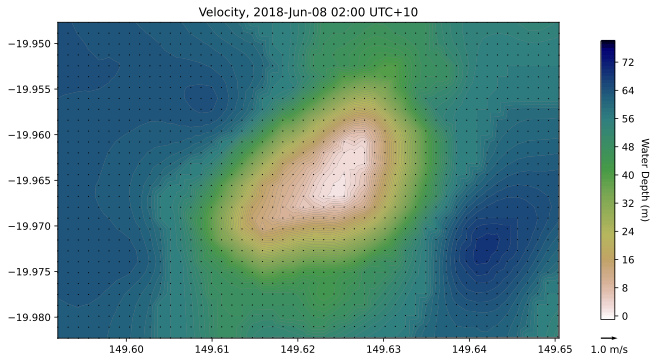

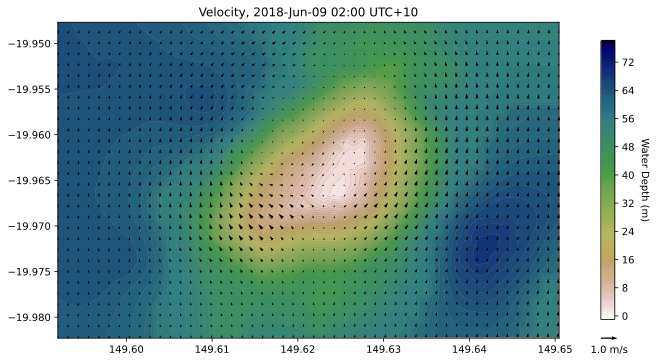

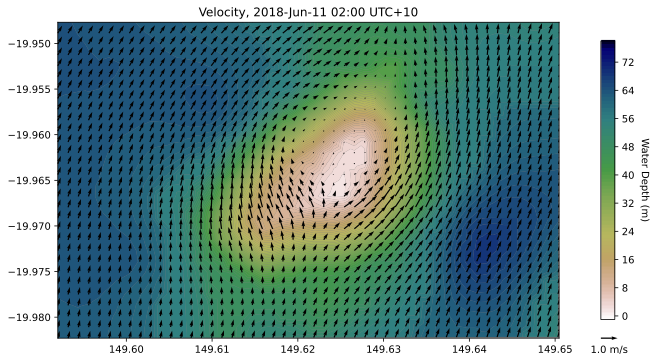

In [14]:
levels = np.arange(-1,h.max()+10,1)
maxvel = 1

# tricontourf plot of water depth with vectors on top
for tstep in range(0,time_var.shape[0]):
    ilayer = -1
    u = ncdata['uav'][tstep, :, :].filled(fill_value=0.)
    v = ncdata['vav'][tstep, :, :].filled(fill_value=0.)

    figure(figsize=(10,10))

    subplot(111,aspect=(1.0/cos(mean(lat)*pi/180.0)))
    tricontourf(meshtri, h.flatten(),levels=levels,cmap=cm.gist_earth_r) #cmocean.cm.deep) #cm.gist_earth)

    gca().patch.set_facecolor('0.5')
    cbar=colorbar(fraction=0.025, pad=0.075)
    cbar.set_label('Water Depth (m)', rotation=-90, labelpad=15)
    ax = cbar.ax

    Q = plt.quiver(lon,lat,u,v,scale=30)
    maxstr='%3.1f m/s' % maxvel
    qk = plt.quiverkey(Q,1.1,0.,maxvel,maxstr,labelpos='S')

    dtime = netCDF4.num2date(time_var[tstep],time_var.units)
    daystr = dtime.strftime('%Y-%b-%d %H:%M')
    title('Velocity, %s UTC+10' % (daystr));